Import Relevant Libraries

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import stax
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from jax.lib import xla_bridge

Define the System Analytically

In [ ]:
# For mass 1, let us call displacements and accelerations z1 and g1. 
# Repeat the same for mass 2 if we wanted another mass in the system.

# The damping coefficient of the system. 
c = 0.05
m1 = 1
m2 = 0
k1 = 1
k2 = 0
g = 9.81
omega = 5

def L(q, q_dot):
  z1, z2 = q
  z1_dot, z2_dot = q_dot 

  # Define the kinetic energies.
  T1 = 0.5 * m1 * (z1_dot**2)
  T2 = 0 # We leave out mass 2 as we're not currently modelling it. 
  T = T1 + T2
  
  # Define the potential energies.
  y1 = 0.5*k1*(z1**2) + m1*g*z1
  y2 = 0 # We leave out mass 2 as we're not currently modelling it. 
  V = y1 + y2

  return T - V

def f_analytical(state, t=0, m1=1, m2=0, k1=1, k2=0, g=9.8):
  z1, z2, z1_dot, z2_dot = state
  g1 =  (m1/m1)*g - (k1/m1)*z1 - (1/m1)*z1**3 - (1/m1)*z1_dot*c  + (np.random.random()/100)
  # g1 =  (m1/m1)*g - (k1/m1)*z1 - (1/m1)*jnp.exp(z1) - (1/m1)*z1_dot*c  + (np.random.random()/100)
  z2_dot = 0
  g2 = 0
  return jnp.stack([z1_dot, z2_dot, g1, g2])

Define Relevant Functions

In [ ]:
def equation_of_motion(D, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = m1*g - k1*q + jax.grad(D)(q, q_t)
  return jnp.concatenate([q_t, q_tt])

# Use the odeint to solve the Lagrangian modelled system.
def solve_damping(D, initial_state, **kwargs):
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, D),
                  initial_state, **kwargs)
  return f(initial_state)

# Use the odeint to solve the system analytically for generating training data. 
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Ensure that all inputs are normalised to only vary between -1 and 1. 
def normalise(state):
  return jnp.concatenate([state[:2], state[2:]])

# Define 4th order Runge-Kutta method for integration of losses. 
def rk4_step(f, x, t, h):
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

Generate Training Data

In [ ]:
time_step = 0.01
N = 5 # How far the training time-series goes. 
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

x0_train = np.array([1.0, 0, 0, 0], dtype=np.float32)
t_train = np.arange(0, 5, 0.01) 
x_train = jax.device_get(solve_analytical(x0_train, t_train)) 
xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) 
y_train = jax.device_get(analytical_step(x_train)) 

# The test dataset is simply a continuation of the training dataset. 
x0_test = x_train[-1, :] # np.array([1.0, 0, 0, 0], dtype=np.float32)
t_test = np.arange(5.0, 10.0, 0.01) 
x_test = jax.device_get(solve_analytical(x0_test, t_test))
xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) 
y_test = jax.device_get(analytical_step(x_test)) 

# Normalise datasets. 
x_train = jax.device_put(jax.vmap(normalise)(x_train))
y_train = jax.device_put(y_train)
x_test = jax.device_put(jax.vmap(normalise)(x_test))
y_test = jax.device_put(y_test)

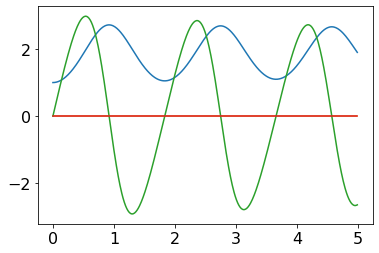

In [ ]:
plt.plot(t_train, x_train)

Initialise Neural Network

In [ ]:
def learned_damping(params):
  def D(q, q_t):
    assert q.shape == (2,)
    state = normalise(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return D

# Now we define the loss function of the model. In our case it is the Mean 
# Squared Error between the predicted and the observed accelerations. 
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_damping(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_damping(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# Set up the Neural Network. 
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

# @jax.jit
# def update_timestep(i, opt_state, batch):
#   params = get_params(opt_state)
#   return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

Train the Neural Network

In [ ]:
%%time
# Initialise the parametes in the neural network to be random. 
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# Define the training process. 
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# Define the training optimiser.
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

# Perform training process. 
for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))*1000
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))*1000
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=52362.593750, test_loss=45542.281250
iteration=1000, train_loss=10.553867, test_loss=65.216515
iteration=2000, train_loss=2.719684, test_loss=18.926258
iteration=3000, train_loss=0.700569, test_loss=4.261871
iteration=4000, train_loss=0.290248, test_loss=2.055377
iteration=5000, train_loss=0.157067, test_loss=1.262291
iteration=6000, train_loss=0.094534, test_loss=0.753658
iteration=7000, train_loss=0.311138, test_loss=0.569416
iteration=8000, train_loss=0.067145, test_loss=0.358256
iteration=9000, train_loss=0.028587, test_loss=0.194457
iteration=10000, train_loss=0.020661, test_loss=0.128882
iteration=11000, train_loss=0.015449, test_loss=0.085972
iteration=12000, train_loss=0.310647, test_loss=0.262611
iteration=13000, train_loss=0.009991, test_loss=0.036293
iteration=14000, train_loss=0.007950, test_loss=0.028869
iteration=15000, train_loss=0.006475, test_loss=0.022180
iteration=16000, train_loss=0.005624, test_loss=0.017503
iteration=17000, train_loss=0.004

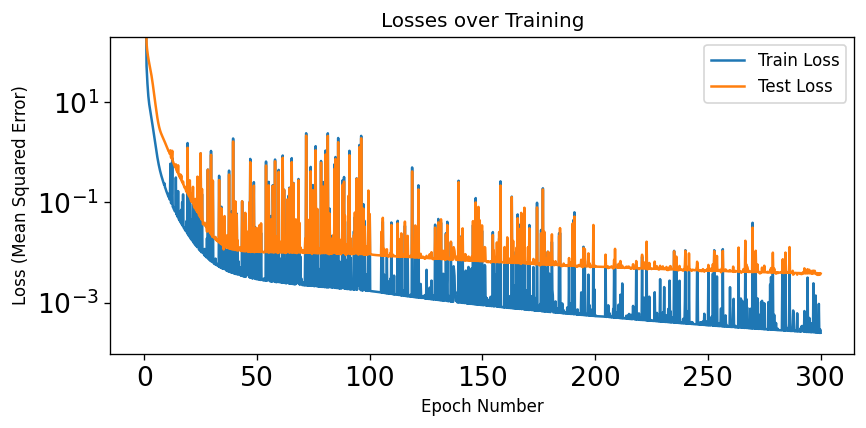

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
epochs = np.linspace(0, ((batch_size/(N/time_step))*num_batches), (num_batches + 1))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over Training')
plt.xlabel("Epoch Number")
plt.ylabel("Loss (Mean Squared Error)")
plt.legend()
plt.show()

Make Predictions Using Trained Model

In [ ]:
# choose an initial state
x1 = np.array([3.0, 0, 0, 0], dtype=np.float32)
time = np.linspace(0, 150, num=4500)
x1_analytical = jax.device_get(solve_analytical(x1, time))
%time x1_model = jax.device_get(solve_damping(learned_damping(params), x1, t=time))

analytical = np.empty(len(time))
model = np.empty(len(time))
forced_displacement = - np.sin(omega*time)

analytical = x1_analytical[:, 0] + forced_displacement
model = x1_model[:, 0] + forced_displacement

CPU times: user 951 ms, sys: 1.44 ms, total: 953 ms
Wall time: 949 ms


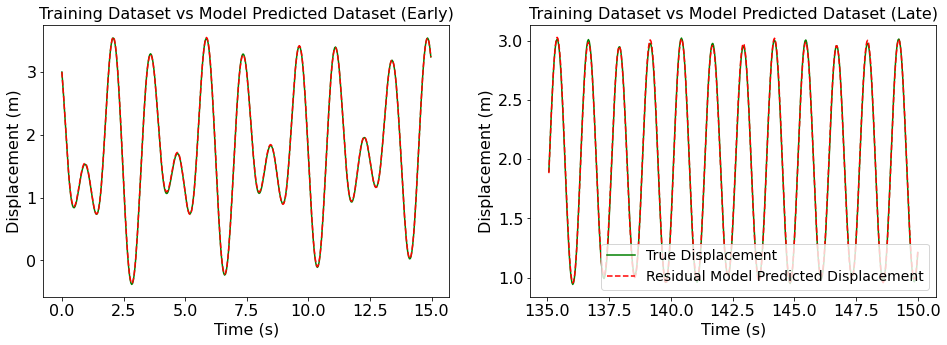

Normalised Root Mean Square Error: 
0.06022


In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16,5))
plt.rc('xtick', labelsize= 16)
plt.rc('ytick', labelsize= 16)

time_1 = time[time<15]
x1_analytical_1 = analytical[time<15]
x1_model_1 = model[time<15]
axis[0].set_title("Training Dataset vs Model Predicted Dataset (Early)", fontsize=16)
axis[0].plot(time_1[time_1<15], x1_analytical_1, 'g-', label=r'True Displacement')
axis[0].plot(time_1, x1_model_1, 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (m)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')

n = max(time) - max(time_1) # Display predicted behaviour for later on. 
time_2 = time[time>n]               
x1_analytical_2 = analytical[time>n]
x1_model_2 = model[time>n]
axis[1].set_title("Training Dataset vs Model Predicted Dataset (Late)", fontsize=16)
axis[1].plot(time_2, x1_analytical_2, 'g-', label=r'True Displacement')
axis[1].plot(time_2, x1_model_2, 'r--', label=r'Residual Model Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (m)", fontsize=16)
axis[1].legend(fontsize=14, loc='lower right')

plt.show()

E2_error = 0
analytical = (x1_analytical[:, 0] - np.mean(x1_analytical[:, 0]))/np.std(x1_analytical[:, 0])
model = (x1_model[:, 0] - np.mean(x1_model[:, 0]))/np.std(x1_model[:, 0])
for i in range(0, len(time)):
  E2_error = E2_error + (abs((analytical[i] - model[i])**2))
E2_error = (E2_error / len(time))**0.5
print("Normalised Root Mean Square Error: ")
print('{0:.5f}'.format(E2_error))

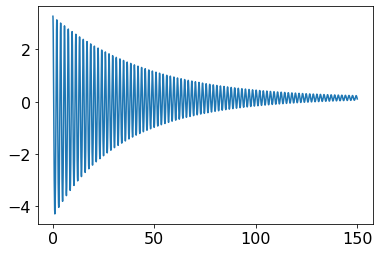

In [ ]:
plt.plot(time, model)

Normalised Root Mean Square Error: 
0.06020


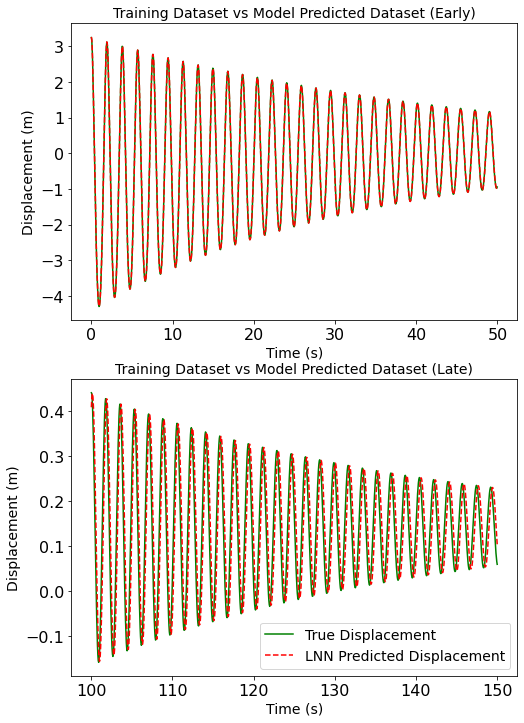

In [ ]:
figure, axis = plt.subplots(2, 1, figsize=(8,12))

time_1 = time[time<50]
x1_analytical_1 = analytical[time<50]
x1_model_1 = model[time<50]
axis[0].set_title("Training Dataset vs Model Predicted Dataset (Early)", fontsize=14)
axis[0].plot(time_1[time_1<50], x1_analytical_1, 'g-', label=r'True Displacement')
axis[0].plot(time_1, x1_model_1, 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=14)
axis[0].set_ylabel("Displacement (m)", fontsize=14)
# axis[0].legend(fontsize=14, loc='lower right')

n = max(time) - max(time_1) # Display predicted behaviour for later on. 
time_2 = time[time>n]               
x1_analytical_2 = analytical[time>n]
x1_model_2 = model[time>n]
axis[1].set_title("Training Dataset vs Model Predicted Dataset (Late)", fontsize=14)
axis[1].plot(time_2, x1_analytical_2, 'g-', label=r'True Displacement')
axis[1].plot(time_2, x1_model_2, 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=14)
axis[1].set_ylabel("Displacement (m)", fontsize=14)
axis[1].legend(fontsize=14, loc='lower right')

plt.rc('xtick', labelsize='LARGE')
plt.rc('ytick', labelsize='LARGE')

E2_error = 0
analytical = (x1_analytical[:, 0] - np.mean(x1_analytical[:, 0]))/np.std(x1_analytical[:, 0])
model = (x1_model[:, 0] - np.mean(x1_model[:, 0]))/np.std(x1_model[:, 0])
for i in range(0, len(time)):
  E2_error = E2_error + (abs((analytical[i] - model[i])**2))
E2_error = (E2_error / len(time))**0.5
print("Normalised Root Mean Square Error: ")
print('{0:.5f}'.format(E2_error))

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.08 s


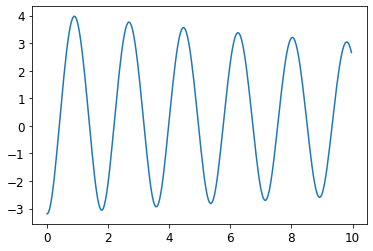

In [ ]:
# choose an initial state
x1 = np.array([2.5, 0, 0, 0], dtype=np.float32)
time = np.linspace(0, 400, num=10000)
x1_analytical = jax.device_get(solve_analytical(x1, time))
%time x1_model = jax.device_get(solve_damping(learned_damping(params), x1, t=time))
q = x1_model[:, 0]
q_t = x1_model[:, 2]
q_tt = np.gradient(x1_model[:, 2])
C = - ((q_tt*m1) + (k1*q) + (q**3) - m1*g)/q
plt.plot(time[:250], C[:250])